<h1 align='center'>Toronto Neighborhoods Clustering</h1>

The data about Toronto neighborhoods is now collected, cleaned and well structered. Its ready to be explored, so we'll cluster all the neighborhoods and try to understand what makes some neighborhoods so similar.

## Import libraires

In [1]:
import pandas as pd
import numpy as np

import requests

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans # import k-means from clustering stage

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

## Load data

In [2]:
toronto_df = pd.read_csv('Toronto_neighborhoods_data.csv')
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.68600,-79.40233
1,M4S,Central Toronto,Davisville,43.70277,-79.38577
2,M4T,Central Toronto,"Moore Park, Summerhill East",43.69050,-79.38297
3,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.69479,-79.41440
4,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.67484,-79.40370


correcting some mistake

In [3]:
toronto_df.columns = ['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']
toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.68600,-79.40233
1,M4S,Central Toronto,Davisville,43.70277,-79.38577
2,M4T,Central Toronto,"Moore Park, Summerhill East",43.69050,-79.38297
3,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.69479,-79.41440
4,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.67484,-79.40370


## Get the list of venues for each neighborhood
### Exploring venues
To be able to get the list of venues for a given neighborhood, we'll be using `Foursquare API`, this REST API takes the following credentials :

In [4]:
CLIENT_ID = 'QPZRG0JP5PLKEYEA24CT3DIU2R1VKLXOM2G4PQVNN3BOTLZK' # your Foursquare ID
CLIENT_SECRET = 'CHNHPEPBTKUHBGN3LSQA5SS5PFDCBNY5KMDKMKL0VQKDL1PF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

The following function explores the venues in a given neighborhood and returns the results in form of a dataframe :

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Retreiving results for :', name, '...')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's explore the neighborhoods in Toronto :

In [6]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Retreiving results for : Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ...
Retreiving results for : Davisville ...
Retreiving results for : Moore Park, Summerhill East ...
Retreiving results for : Forest Hill North & West, Forest Hill Road Park ...
Retreiving results for : The Annex, North Midtown, Yorkville ...
Retreiving results for : Davisville North ...
Retreiving results for : Roselawn ...
Retreiving results for : North Toronto West,  Lawrence Park ...
Retreiving results for : Lawrence Park ...
Retreiving results for : Berczy Park ...
Retreiving results for : Christie ...
Retreiving results for : Central Bay Street ...
Retreiving results for : First Canadian Place, Underground city ...
Retreiving results for : Toronto Dominion Centre, Design Exchange ...
Retreiving results for : Church and Wellesley ...
Retreiving results for : University of Toronto, Harbord ...
Retreiving results for : Queen's Park, Ontario Provincial Government ...
Retreiving results for : Ro

### Inspect the results

In [7]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Summerhill West, Rathnelly, South Hill, Forest...",43.686,-79.40233,The Market By Longo’s,43.686711,-79.399536,Supermarket
1,"Summerhill West, Rathnelly, South Hill, Forest...",43.686,-79.40233,LCBO,43.686991,-79.399238,Liquor Store
2,"Summerhill West, Rathnelly, South Hill, Forest...",43.686,-79.40233,Starbucks,43.686756,-79.398292,Coffee Shop
3,"Summerhill West, Rathnelly, South Hill, Forest...",43.686,-79.40233,Tim Hortons,43.687682,-79.396840,Coffee Shop
4,"Summerhill West, Rathnelly, South Hill, Forest...",43.686,-79.40233,TTC Stop #,43.685826,-79.404981,Light Rail Station


In [8]:
print('The process gives a total of {} venues in Toronto.'.format(toronto_venues.shape[0]))

The process gives a total of 2138 venues in Toronto.


In [9]:
print('There are {} uniques categories for the venues.'.format(len(toronto_venues['Venue Category'].unique())))

There are 251 uniques categories for the venues.


### Processing the results
Our goal here is to find the most common venues categories for each neighborhood. In order to do that :
#### 1. Count the perecentage of each venue category in each neighborhood :

In [10]:
# one hot encoding
neigh_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neigh_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [neigh_onehot.columns[-1]] + list(neigh_onehot.columns[:-1])
neigh_onehot = neigh_onehot[fixed_columns]

neigh_grouped = neigh_onehot.groupby('Neighborhood').mean().reset_index()
neigh_grouped.head()

,Neighborhood,Yoga Studio,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0625,0.00,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0000,0.00,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.02,0.0,0.01,0.0,0.01,0.02,0.0,...,0.0,0.0,0.0,0.02,0.0,0.0000,0.01,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0000,0.00,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0000,0.00,0.0,0.0,0.0


#### 2. Extract the top 10 venues for each neighborhood :

In [11]:
# this function returns the top n venues categories for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neigh_grouped['Neighborhood']

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Alderwood, Long Branch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Bathurst Manor, Wilson Heights, Downsview North",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bayview Village,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bedford Park, Lawrence Manor East",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# populate the dataframe with the corresponding values
for ind in np.arange(neigh_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neigh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Pool,Discount Store,Bubble Tea Shop,Supermarket,Sushi Restaurant,Bakery,Badminton Court,Skating Rink
1,"Alderwood, Long Branch",Pharmacy,Garden Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Hotel,Café,Sushi Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Italian Restaurant,Japanese Restaurant
3,Bayview Village,Pizza Place,Coffee Shop,Fast Food Restaurant,Restaurant,Poutine Place,Mediterranean Restaurant,Italian Restaurant,Gastropub,Indie Movie Theater,Ice Cream Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Indian Restaurant,Butcher,Café,Breakfast Spot,Restaurant,Sports Club,Pub


## Neighborhoods clustering

In [14]:
# set number of clusters
kclusters = 3

neigh_grouped_clustering = neigh_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neigh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1])

In [15]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.68600,-79.40233,1.0,Coffee Shop,Light Rail Station,Liquor Store,Supermarket,Women's Store,Farm,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant
1,M4S,Central Toronto,Davisville,43.70277,-79.38577,1.0,Coffee Shop,Pizza Place,Sandwich Place,Café,Italian Restaurant,Dessert Shop,Seafood Restaurant,Restaurant,Sushi Restaurant,Fast Food Restaurant
2,M4T,Central Toronto,"Moore Park, Summerhill East",43.69050,-79.38297,1.0,Convenience Store,Tennis Court,Gym,Playground,Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
3,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.69479,-79.41440,1.0,Park,Basketball Court,Women's Store,Eastern European Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
4,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.67484,-79.40370,1.0,Café,Sandwich Place,Indian Restaurant,Liquor Store,Flower Shop,Mexican Restaurant,Middle Eastern Restaurant,Restaurant,French Restaurant,Modern European Restaurant


In [16]:
toronto_merged['Cluster Labels'].value_counts()

1.0    94
0.0     6
2.0     1
Name: Cluster Labels, dtype: int64

## Examine clustering results
### Toronto's Map
Drop neighborhoods with no results

In [17]:
toronto_merged.dropna(inplace=True)

Get Toronto geo-coordinates

In [18]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Plot Toronto's map with clustered neighborhoods

In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each cluster
To examine each cluster results, we'll plot the **top n venues** with their corresponding ranking as a common venue. To do that, we'll create the contingency table for each category against the ranking and then plot a stacked horizontal bar plot. The following function will help to do this :

In [20]:
def cluster_plot(df, cluster, min_occ=None) :
    # grab the cluster members
    clus = df.loc[df['Cluster Labels'] == cluster, [venue for venue in df.columns if 'Venue' in venue]]
    
    # compute the occurence of each venue in each rank
    res = dict()
    for col in clus.columns :
        res[col] = clus[col].value_counts()
    
    # transorm the result into a dataframe
    temp = pd.DataFrame(res)
    temp = temp.fillna(0)
    
    # filter the results based on the value of the minimum occurency wanted
    temp['total'] = temp.sum(axis=1)
    temp.sort_values('total', inplace=True)
    
    if min_occ and (min_occ < max(temp.total)):
        temp = temp[temp.total >= float(min_occ)]
    else :
        print('Cluster {} don\'t have venues with an occurence greater or equal to {}!'.format(cluster, min_occ))
        print('Plotting top 10 venues instead...')
        temp = temp.iloc[:10]

    temp.drop('total', 1, inplace=True)

    # plot the results
    temp.plot.barh(stacked=True)
    plt.title('Cluster {}'.format(cluster), y=1.02)
    plt.ylabel('Category')
    plt.xlabel('Occurence')
    
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20, 10),
             'axes.labelsize': 20,
             'axes.titlesize':30,
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    plt.show()

Cluster 0 don't have venues with an occurence greater or equal to 15!
Plotting top 10 venues instead...


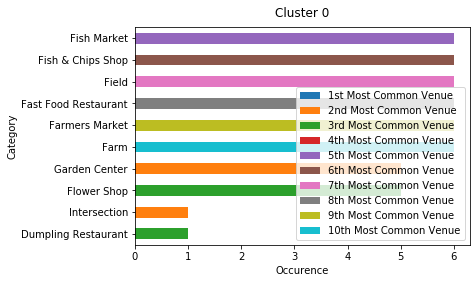

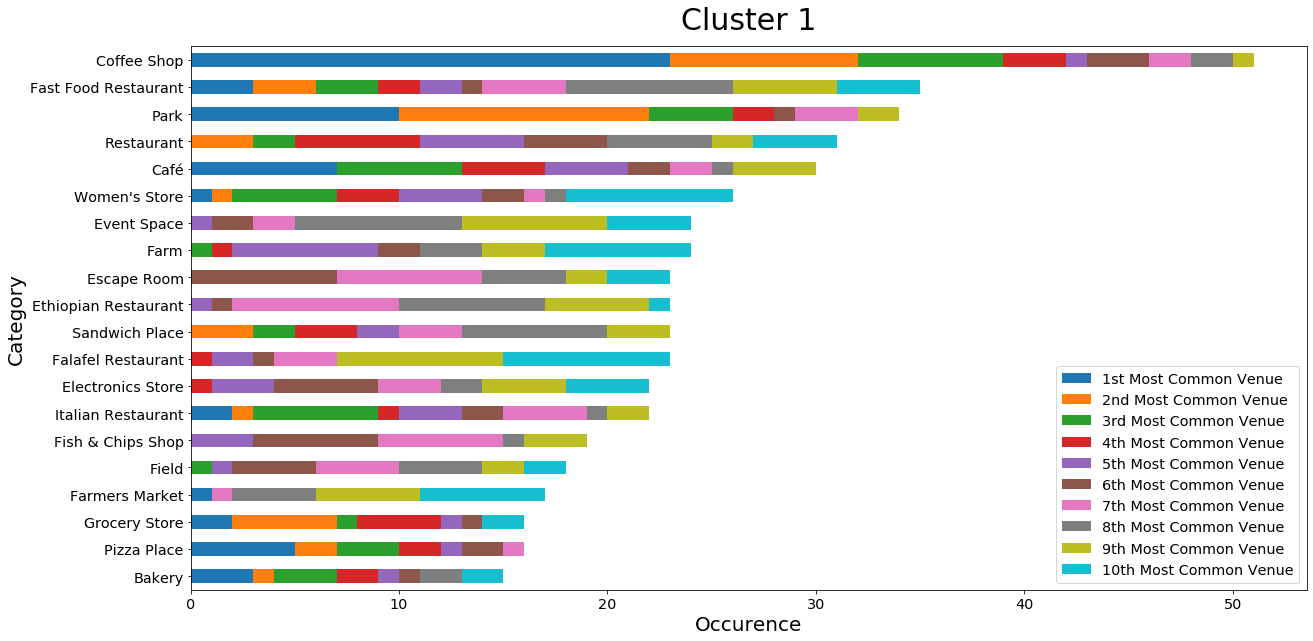

Cluster 2 don't have venues with an occurence greater or equal to 15!
Plotting top 10 venues instead...


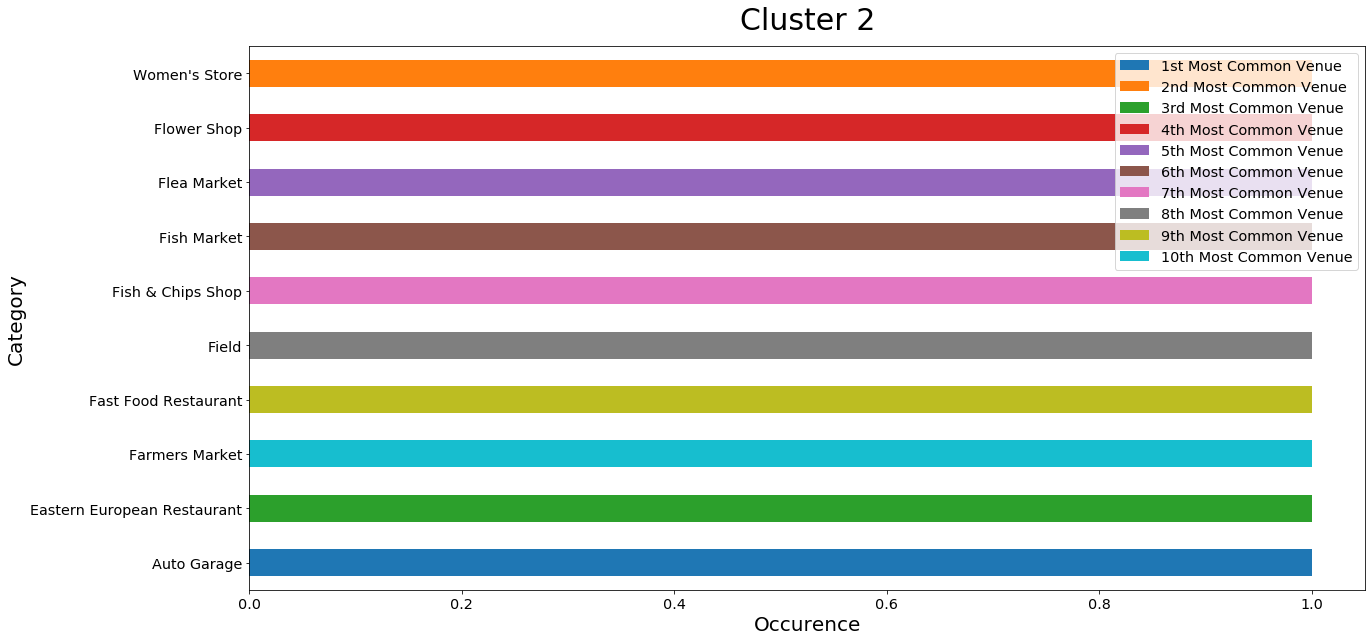

In [21]:
for cluster in range(kclusters) :
    cluster_plot(toronto_merged, cluster, 15)

#### Observations
**1 Cluster 0** :
* Examining the top venues in this cluster, it appears that its neighborhoods represents the countryside, with farms, fields and garden centers.. also farmers markets and fish markets.

**2 Cluster 1** :
* Neighborhoods in this cluster are the the typical representation of modern and populated cities.
* Coffe shops and food places are the most common venues. These are places where people are working and they need fast services.

**3 Cluster 2** :
* These are a quiet places to live in. No coffe shops, only two restaurants and some stores and markets